## Imports and Reading Datasets

In [3]:
from uszipcode import SearchEngine
import pandas as pd
import numpy as np
import random

search = SearchEngine(simple_zipcode=True)
df = pd.read_csv('./datasets/iowaliquor.csv')[['Date', 'Store Name', 'Zip Code', 'Sale (Dollars)', 'County']]

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# get 2016 election data and filter for Iowa results only 
election_df = pd.read_csv('./datasets/usa-2016-presidential-election-by-county.csv', sep=';')
election_df = election_df[election_df['State'] == 'Iowa']

In [25]:
# delete this
election_df.head()['Less Than High School Diploma']

63     11.9
90     10.3
127    13.2
140    10.4
177    12.4
Name: Less Than High School Diploma, dtype: float64

## Fill Missing Zip Codes

In [5]:
unqs = df[df["Zip Code"].isna()]["Store Name"].unique() # get unique store names
cities = [store.split("/")[-1].strip().lower() for store in unqs if "/" in store] # extract city name
if "mlk" in cities:
    cities.remove("mlk")
subset = df[df["Store Name"].str.contains("/") & (df["Zip Code"].isna())] 
city_dict = {}
for city in set(cities): # get zip code from rows with cities in store name
    city_dict[city] = search.by_city_and_state(city, "iowa")[0].zipcode
city_dict["mlk"] = '50310'
df.loc[subset.index, 'Zip Code'] = subset["Store Name"].str.split("/").str[-1].str.strip().str.lower().map(city_dict) 

## Aggregate and Get Zip Code Statistics

In [6]:
df["YearMonth"] = df["Date"].str.split("/").str[2] + "-" + df["Date"].str.split("/").str[0]

df = df[df["Zip Code"].notna()]
df["Zip Code"] = df["Zip Code"].replace("712-2", 51529) 
df["Zip Code"] = df["Zip Code"].astype(int) 

countyDict = {}
popDict = {}

for zc in df["Zip Code"].unique():
    stats = search.by_zipcode(zc)
    if stats.state == "IA":
        countyDict[zc] = stats.county
        popDict[zc] = stats.population

In [27]:
df.head()

,Date,Store Name,Zip Code,Sale (Dollars),County,YearMonth
0,10/04/2012,Kum & Go #573 / SE 14th DM,50315,17.25,Polk,2012-10
1,12/20/2014,Roy's Foodland,52332,27.66,Benton,2014-12
2,09/09/2013,Wal-Mart 1528 / Cedar Rapids,52402,134.76,Linn,2013-09
3,12/12/2012,No Frills Supermarkets #803 / Glenwo,51534,495.60,Mills,2012-12
4,10/14/2015,Hy-Vee Food Store / Sioux City,51106,121.56,Woodbury,2015-10


In [7]:
totalZip = pd.DataFrame(df.groupby(["YearMonth", "Zip Code"])["Sale (Dollars)"].sum())
totalZip.reset_index(inplace=True)
totalZip["Population"] = totalZip["Zip Code"].map(popDict)

## County Aggregate & Add Election Data

In [8]:
totalZip["County"] = totalZip["Zip Code"].map(countyDict)
totalZip.dropna(inplace=True)
totalCounty = pd.DataFrame(totalZip.groupby(["YearMonth", "County"])["Sale (Dollars)"].sum())
totalCounty.reset_index(inplace=True)
totalCounty["Month"] = totalCounty["YearMonth"].str.split("-").str[-1]

election_df["County"] = election_df["County"].str.replace(', Iowa', "")
totalCounty = totalCounty.merge(election_df, on="County")
totalCounty["SalesPerCapita"] = totalCounty["Sale (Dollars)"] / totalCounty["Total Population"]

In [26]:
totalZip.head()

,YearMonth,Zip Code,Sale (Dollars),Population,County
0,2012-01,50002,2865.89,1297.0,Adair County
1,2012-01,50003,12127.81,6594.0,Dallas County
2,2012-01,50006,8519.98,1676.0,Hardin County
3,2012-01,50009,90278.27,16136.0,Polk County
4,2012-01,50010,386395.66,29359.0,Story County


## Unemployment Data

In [10]:
totalCounty = pd.read_csv("totalCounty.csv").drop("Unnamed: 0", axis=1)
totalCounty["Year"] = totalCounty["YearMonth"].str.split("-").str[0]
unemployment_df = pd.read_csv("./datasets/iowa_unemployment.csv")
unemployment_df.rename(columns={"County Name": "County"}, inplace=True)
unemployment_df["Year"] = unemployment_df["Year"].astype(str)
unemployment_df["County"] = unemployment_df["County"] + " County"
totalCounty = pd.merge(totalCounty, unemployment_df,  how='left', left_on=['County','Year'], right_on = ['County','Year'])

In [20]:
unemployment_df.head()

,Year,County,Benefits Paid,Weeks Compensated,Recipients,First Payments,Final Payments,County FIP,GNIS Feature ID,Primary Lat Dec,Primary Long Dec,Primary County Coordinates
0,2019,Worth County,971612,2529,290,234,32,19195,465286,43.377398,-93.260848,POINT (-93.2608476 43.3773984)
1,2019,Woodbury County,10148200,25818,2505,2060,463,19193,465285,42.389717,-96.044767,POINT (-96.0447673 42.3897169)
2,2019,Wright County,1175326,3132,336,293,73,19197,465287,42.733119,-93.735146,POINT (-93.7351465 42.7331189)
3,2019,Winneshiek County,2764203,6775,574,508,101,19191,465284,43.290675,-91.843707,POINT (-91.8437074 43.2906746)
4,2019,Winnebago County,1251960,3657,560,503,56,19189,465283,43.377568,-93.734195,POINT (-93.7341955 43.37756780000001)


## Transform Variables

In [11]:
totalCounty["LogSPC"] = np.log(totalCounty["SalesPerCapita"])
totalCounty["LogBachelors"] = np.log(totalCounty["At Least Bachelors's Degree"])
totalCounty["LogPop"] = np.log(totalCounty["Total Population"])
totalCounty["YearsPast2012"] = totalCounty["YearMonth"].str.split("-").str[0].astype(int) - 2012
totalCounty["Adult.smoking"] = totalCounty["Adult.smoking"].replace(np.nan, totalCounty["Adult.smoking"].mean())
totalCounty["BenefitsPerPerson"] = totalCounty["Benefits Paid"] / totalCounty["Total Population"]
totalCounty["Month"] = totalCounty["Month"].astype(str)
totalCounty["Intercept"] = 1
totalCounty["MedianAge*LogPop"] = totalCounty["Median Age"] * totalCounty["LogPop"]
totalCounty["MedianAge*Obesity"] = totalCounty["Median Age"] * totalCounty["Adult.obesity"]
totalCounty["MedianWage*Republicans2012"] = totalCounty["Median Earnings 2010"] * totalCounty["Republicans 2012"]
totalCounty["White*LogPop"] = totalCounty["White"] * totalCounty["LogPop"]

## Linear Regression

In [12]:
cols = ["Intercept", "Month", "Median Age", "Adult.obesity", "Diabetes", "White", "Less Than High School Diploma", "LogBachelors", "LogPop", "Median Earnings 2010", "YearsPast2012", "Adult.smoking", "Republicans 2012", "BenefitsPerPerson", "School Enrollment", "MedianAge*LogPop", "MedianAge*Obesity", "MedianWage*Republicans2012", "White*LogPop"]
X = totalCounty[cols].dropna()
y = np.array(totalCounty['LogSPC'].loc[X.index])
X = pd.get_dummies(X, drop_first=True)
dummy_cols = X.columns
X = np.array(X)

b = np.linalg.inv(X.T@X)@X.T@y

np.sqrt(((np.e**y - np.e**(X@b))**2).mean())

2.495805686940038

## Cross Validation

In [13]:
indices = [i for i in range(X.shape[0])]
group_size = X.shape[0] // 4
groups = []

for i in range(3):
    cur_group = random.sample(indices, group_size)
    groups.append(cur_group)
    for ind in cur_group:
        indices.remove(ind)
        
groups.append(indices)

In [14]:
scores = []
for i in range(4):
    train_inds = sum([groups[j] for j in range(len(groups)) if j != i], [])
    X_train = X[train_inds]
    X_test = X[groups[i]]
    y_train = y[train_inds]
    y_test = y[groups[i]]
    
    b = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
    scores.append(np.sqrt(((np.e**y_test - np.e**(X_test@b))**2).mean()))
    
np.mean(scores)

2.4979047774477516

## AIC Score

In [15]:
def get_aic_score(X):
    indices = [i for i in range(X.shape[0])]
    group_size = X.shape[0] // 4
    groups = []

    for i in range(3):
        cur_group = random.sample(indices, group_size)
        groups.append(cur_group)
        for ind in cur_group:
            indices.remove(ind)

    groups.append(indices)

    aic_scores = []
    for i in range(4):
        train_inds = sum([groups[j] for j in range(len(groups)) if j != i], [])
        X_train = X[train_inds]
        X_test = X[groups[i]]
        y_train = y[train_inds]
        y_test = y[groups[i]]

        b = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
        residuals = np.e**y_test - np.e**(X_test@b)
        aic_scores.append((residuals**2).sum() / np.std(y_test)**2 + 2*X_train.shape[1])

    return np.mean(aic_scores)

get_aic_score(X)

34587.264434194614

## Calculate R^2

In [16]:
predictions = np.e**(X@b)
actual = np.e**y

ssTot = ((actual.mean() - actual)**2).sum()
ssRes = ((predictions - actual)**2).sum()

R2 = 1 - ssRes/ssTot
R2

0.47372805263994144

## Slope Confidence Intervals

In [17]:
bounds = []
t = 1.96
for i, col in enumerate(dummy_cols):
    var = X[:,i]
    se = np.sqrt(((predictions - actual)**2).sum() / (len(actual) - 2)) / np.sqrt(((var - var.mean())**2).sum())
    bounds.append((b[i] - se*t, b[i] + se*t))
    
ci_df = pd.DataFrame({"Variable": dummy_cols, "Bounds": bounds})

ci_df.head()

<ipython-input-17-6daf4f5ed440>:5: RuntimeWarning: divide by zero encountered in double_scalars
  se = np.sqrt(((predictions - actual)**2).sum() / (len(actual) - 2)) / np.sqrt(((var - var.mean())**2).sum())


,Variable,Bounds
0,Intercept,"(-inf, inf)"
1,Median Age,"(-0.827416651079902, -0.7996457217695706)"
2,Adult.obesity,"(-31.89564732904746, -27.61641559918746)"
3,Diabetes,"(-5.931947947151518, 3.8908850365192977)"
4,White,"(0.09211853261714108, 0.1108785345708684)"


## Predicted vs. Actual Plot

In [43]:
res = pd.DataFrame({"Predictions": predictions, "Actual": actual})

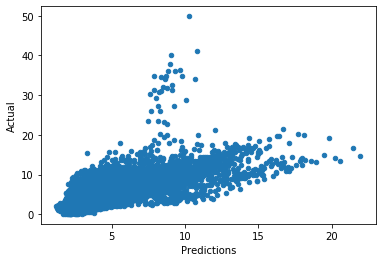

In [44]:
res.plot.scatter("Predictions", "Actual")

## Model Selection

In [19]:
# remove unimportant variables 
cols = ["Intercept", "Month", "Median Age", "Adult.obesity", "Diabetes", "White", "Less Than High School Diploma", "LogBachelors", "LogPop", "Median Earnings 2010", "YearsPast2012", "Adult.smoking", "Republicans 2012", "School Enrollment", "MedianAge*LogPop", "MedianAge*Obesity", "MedianWage*Republicans2012", "White*LogPop"]
done = False

while not done:
    aic_scores = []
    X = totalCounty[cols].dropna()
    y = np.array(totalCounty['LogSPC'].loc[X.index])
    X = pd.get_dummies(X, drop_first=True)
    X = np.array(X)
    initial_aic = get_aic_score(X)
    print(initial_aic)
    for col in cols: 
        X = totalCounty[cols].dropna().drop(col, axis=1)
        y = np.array(totalCounty['LogSPC'].loc[X.index])
        X = pd.get_dummies(X, drop_first=True)
        X = np.array(X)
        aic_scores.append(get_aic_score(X))
    scores = pd.DataFrame({"Column": cols, "AIC Score": aic_scores})
    if min(aic_scores) > initial_aic:
        done = True
    else:
        display(scores.sort_values("AIC Score"))
        removed_col = scores.sort_values("AIC Score")["Column"].iloc[0]
        print("Removed Column: ", removed_col)
        cols.remove(removed_col)

38069.25348853372


,Column,AIC Score
5,White,37725.266136
17,White*LogPop,37892.048790
11,Adult.smoking,38066.319010
4,Diabetes,38171.061147
12,Republicans 2012,38183.628680
15,MedianAge*Obesity,38226.256886
3,Adult.obesity,38238.181999
16,MedianWage*Republicans2012,38326.250209
6,Less Than High School Diploma,38408.772751
2,Median Age,38677.563696


Removed Column:  White
37906.834736192046


,Column,AIC Score
10,Adult.smoking,37839.430367
11,Republicans 2012,37955.839569
4,Diabetes,37967.986944
15,MedianWage*Republicans2012,37970.719014
14,MedianAge*Obesity,38179.008008
3,Adult.obesity,38249.829197
5,Less Than High School Diploma,38399.250307
8,Median Earnings 2010,38520.621857
6,LogBachelors,38744.963369
16,White*LogPop,38790.138513


Removed Column:  Adult.smoking
37733.73521100529


In [ ]:
# 